In [229]:
import sqlite3
import pandas as pd
import json
import tweepy
import csv
import datetime

In [230]:
class projek:
    def __init__(self, file_db, file_csv):
        self.file_db = file_db
        self.file_csv = file_csv
        
    def open_connect(self):
        self.connection = sqlite3.connect(self.file_db)
        print("Koneksi dibuka")
        
    def get_data(self, date, dateuntil, jumlah_tweet, topik, bahasa):
        
        token_file = open(self.file_csv)
        token = csv.reader(token_file, delimiter=',')
        list_token = [col[1] for col in token]
    
        consumer_key = list_token[0]
        consumer_secret = list_token[1]
        access_token = list_token[2]
        access_token_secret = list_token[3]
        
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        api = tweepy.API(auth)
        
        query = topik + '-filter:retweets'
        tweet_properties = []
        
        for tweet in tweepy.Cursor(api.search, q= query, lang = bahasa, since = date, until=dateuntil, tweet_mode = 'extended').items(jumlah_tweet):
            user_id = tweet.user.id
            tweet_id = tweet.id
            tweet_text = tweet.full_text
            tweet_created =  tweet.created_at
            username = tweet.user.name
            screen_name = tweet.user.screen_name
            lokasi = tweet.user.location
            user_created =  tweet.user.created_at
            followers = tweet.user.followers_count
            friends = tweet.user.friends_count
            verified =  tweet.user.verified
            tweet_properties.append({'tweet_id': tweet_id, 'tweet_created_at':tweet_created, 'user_id': user_id, 'Tweet':tweet_text, 'username':username,
                                  'screen name': screen_name, 'lokasi':lokasi, 'user_created': user_created, 'followers count':followers,
                                  'friends count':friends, 'verified':verified})
        df = pd.DataFrame(tweet_properties)
            
        return df
    
    def save_sql(self, df):
        self.cursor = self.connection.cursor()
        
        # scraping_manipulation
        status_lama = 0 #inactive
        scraping_id = 1
        status_baru = 1 #active
        self.cursor.execute("SELECT * FROM Lastscraping ORDER BY scraping_id DESC LIMIT 1")
        result = self.cursor.fetchone()
        
        if(result is None):
            pass
        else:
            scraping_id = result[0] + scraping_id
            query_edit_scraping = 'UPDATE Lastscraping SET status = ? WHERE scraping_id=? ;' #ubah status aktif menjadi tidak aktif
            val_edit_scraping = [status_lama, result[0]]
            self.cursor.execute(query_edit_scraping, val_edit_scraping)

        date =str(datetime.datetime.now())
        date = date[:11] #ambil yyyy-mm-dd
        query_last_scraping = 'INSERT INTO Lastscraping (scraping_id, last_get, status) VALUES (?,?,?);'
        val = [scraping_id, date, status_baru]
        self.cursor.execute(query_last_scraping,val)    

        #tweet and user_id manipulation
        for row in df.index:
            tweet_id = df['tweet_id'][row]
            tweet_id = int(tweet_id)
            tweet_created_at = df['tweet_created_at'][row]
            tweet_date= datetime.date(tweet_created_at.year, tweet_created_at.month, tweet_created_at.day)
            user_id = df['user_id'][row]
            user_id = int(user_id)
            tweet = df['Tweet'][row]
            username = df['username'][row]
            screen_name = df['screen name'][row]
            user_location = df['lokasi'][row]
            user_created = df['user_created'][row]
            user_date = datetime.date(user_created.year, user_created.month, user_created.day)
            followers_number = int(df['followers count'][row])
            friends_number = int(df['friends count'][row])
            if (df['verified'][row] == False):
                user_verified = 0
            else:
                user_verified = 1

            query_insert_tweet = 'INSERT OR IGNORE INTO Tweet (tweetid, userid, createddate, tweet, scraping_id) VALUES (?,?,?,?,?);'
            val_tweet = [tweet_id, user_id, tweet_date, tweet, scraping_id]
            self.cursor.execute(query_insert_tweet, val_tweet)
            print("data tweet masuk")

            
            query_insert_user = 'INSERT OR IGNORE INTO User (userid, name, screenname, location, acccreated, follower, friend, verified) '\
                                'VALUES (?,?,?,?,?,?,?,?);'
            val_user = [user_id, username, screen_name, user_location,
                   user_date, followers_number, friends_number, user_verified]
            self.cursor.execute(query_insert_user, val_user)
            print("data user masuk")
            print('=================================================================')

    def close_connect(self):
        self.connection.commit()
        self.connection.close()
        print("Koneksi ditutup")
    
        
    def clean_data(self):
        from nltk.corpus import stopwords
        from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
        from nltk.tokenize import word_tokenize
        import re
        
        indonesia_s = stopwords.words('indonesian')
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        
        query_ambil = '''SELECT tweetid, tweet from Tweet WHERE cleantweet IS NULL  '''
                
        self.cursor = self.connection.cursor()
        self.cursor.execute(query_ambil)
        hasil = self.cursor.fetchall()
        hasil = pd.DataFrame(hasil, columns=['ID','Tweet'])
        clean_text=[]
        for sentence in hasil['Tweet']:
            clean = sentence.lower()
            clean = ' '.join(re.sub("([0-9 \t]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", clean).split()) 
            stop_words = set(indonesia_s)
            word_tokens = word_tokenize(clean) 
            clean = ' '.join([w for w in word_tokens if not w in stop_words])
            clean = stemmer.stem(clean)
            clean_text.append(clean)
        hasil['clean_tweet'] = clean_text
        hasil["ID"]= pd.to_numeric(hasil["ID"])
        for row in hasil.index:
            clean_tweet = hasil['clean_tweet'][row]
            tweet_id = hasil['ID'][row]
            tweet_id = int(tweet_id)
            query_insert_tweet = 'UPDATE Tweet SET cleantweet = ? WHERE tweetid = ?;'           
            val_tweet = [clean_tweet, tweet_id]
            self.cursor.execute(query_insert_tweet, val_tweet)
        self.cursor.close()
        print("tweet bersih masuk")
        

In [237]:
tweet1 = projek(file_db='hanaizdihar20_tugas12.db', file_csv='token2.csv')
tweet1.open_connect()
df=tweet1.get_data('2020-11-21', '2020-11-22', 200, 'covid', 'id')
tweet1.save_sql(df)
tweet1.clean_data()
tweet1.close_connect()

Koneksi dibuka
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user masuk
data tweet masuk
data user m

tweet bersih masuk
Koneksi ditutup


In [434]:
#EDA

query ='''select t.tweetid, t.createddate, t.cleantweet, u.name, u.location, u.follower, u.friend, u.verified from Tweet t 
        inner join User u on t.userid = u.userid '''
connection = sqlite3.connect('hanaizdihar20_tugas12.db')
cursor = connection.cursor()
cursor.execute(query)
hasil = cursor.fetchall()
cursor.close()
connection.close()

In [435]:
df = pd.DataFrame(columns=['tweetid','Date', 'Tweet', 'Name', 'Location', 'Follower', 'Friend', 'Verified'])
tweetid, date, tweet, name, loc, follower, friend, verified = [], [], [], [], [], [], [], []
for item in hasil:
    tweetid.append(item[0])
    date.append(item[1])
    tweet.append(item[2])
    name.append(item[3])
    loc.append(item[4])
    follower.append(item[5])
    friend.append(item[6])
    verified.append(item[7])

In [436]:
df['tweetid'] = tweetid
df['Date']= date
df['Tweet']= tweet
df['Name'] = name
df['Location']= loc
df['Follower'] = follower
df['Friend'] = friend
df['Verified'] = verified

In [437]:
df['tweetid'] = pd.to_numeric(df['tweetid'])
df['Follower'] = pd.to_numeric(df['Follower'])
df['Friend'] = pd.to_numeric(df['Friend'])
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,tweetid,Date,Tweet,Name,Location,Follower,Friend,Verified
0,1330287374463623172,2020-11-21,presiden ri joko widodo jokowi klaim omnibus l...,Jonyy89,,1,2,0
1,1330287671583838209,2020-11-21,dennysiregar doa manjur hrs ga sampe minggu la...,Dawantea2,,76,104,0
2,1330287692731584516,2020-11-21,orchidpoison tahun covid bener bener diet air ...,Rotus,,91,345,0
3,1330287714529390597,2020-11-21,cegah covid belanja pandemi covid diam rumah t...,Humaskintap,Jl. A. Yani Km. 01 Kintapura,119,102,0
4,1330287856485588998,2020-11-21,sarawak catat sifar kes covid pkpb kuching tamat,FA,Kuala Lumpur Federal Territory,20680,840,1


In [438]:
df.describe()

,tweetid,Follower,Friend,Verified
count,1.400000e+03,1.400000e+03,1400.000000,1400.000000
mean,1.331382e+18,1.208168e+05,591.345000,0.083571
std,7.252233e+14,6.577404e+05,1350.371286,0.276843
min,1.330287e+18,0.000000e+00,0.000000,0.000000
25%,1.330660e+18,3.700000e+01,32.750000,0.000000
50%,1.331383e+18,2.860000e+02,178.500000,0.000000
75%,1.332104e+18,1.542000e+03,559.000000,0.000000
max,1.332474e+18,1.637478e+07,20950.000000,1.000000


# Trend Analysis

In [439]:
#plot sentimen per hari
#plot kata perhari
pos_list= open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()

sen = []
total = []
jum = 0
res = []
dateunik = []
for index in df.index:
    indexmin = index-1
    if index == 0:
        jum+=1
    elif df['Tweet'][index] == np.nan:
        pass
    elif df['Date'][index] == df['Date'][indexmin]:
        jum+=1
        count_p = 0
        count_n = 0
        date = df['Date'][index]
        for kata_pos in pos_kata:
            if kata_pos.strip() in df['Tweet'][index]:
                count_p +=1
        for kata_neg in neg_kata:
            if kata_neg.strip() in df['Tweet'][index]:
                count_n +=1
        res.append(count_p - count_n)
    else:
        ave = np.mean(res)
        sen.append(ave)
        total.append(jum)
        dateunik.append(date)
        jum = 0
        res = []           

In [465]:
tanggal=[]
for item in dateunik:
    tanggal.append(str(str(item.year)+'-'+ str(item.month)+ '-'+ str(item.day)))
tanggal = pd.DataFrame(tanggal, columns=['date'])
tanggal = pd.to_datetime(tanggal['date'])

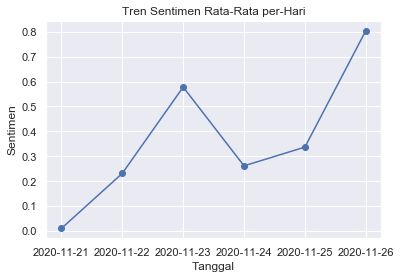

In [467]:
plt.plot(apa, sen, marker='o', color='b')
plt.title('Tren Sentimen Rata-Rata per-Hari')
plt.xlabel('Tanggal')
plt.ylabel('Sentimen')
plt.grid()

# EDA

In [427]:
import numpy as np
df.Date.replace (r'^\s*$', regex = True, inplace = True)
df.Tweet.replace (r'^\s*$', np.nan, regex = True, inplace = True)
df.Name.replace (r'^\s*$', np.nan, regex = True, inplace = True)
df.Location.replace (r'^\s*$', np.nan, regex = True, inplace = True)
df.Follower.replace (r'^\s*$', np.nan, regex = True, inplace = True)
df.Friend.replace (r'^\s*$', np.nan, regex = True, inplace = True)
df.Verified.replace (r'^\s*$', np.nan, regex = True, inplace = True)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\missing.py:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [428]:
def df_na(dataframe):
    na = dataframe.isnull().sum()/len(dataframe)
    na = na[na>0]
    na.sort_values(inplace=True)
    return na

def plot(dataframe):
    na = df_na(dataframe)
    na = na.to_frame()
    na.columns = ['Jumlah']
    na.index.names = ['Nama']
    na['Nama'] = na.index
    sns.set(style='dark')
    sns.barplot(x='Nama', y='Jumlah', data=na)
    plt.xticks(rotation=90)
    plt.show()
    
df_na(df)

Tweet       0.000714
Location    0.411429
dtype: float64

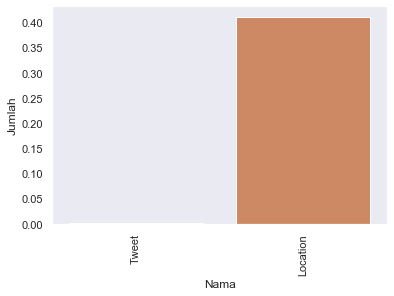

In [429]:
plot(df)

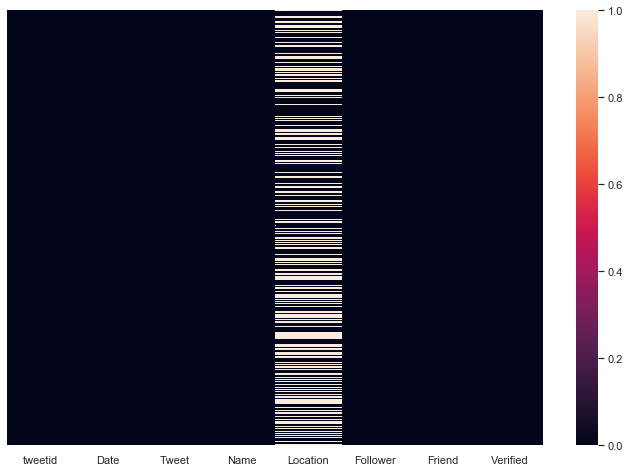

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)

In [245]:
df.head(100)

,tweetid,Date,Tweet,Name,Location,Follower,Friend,Verified
0,1330287374463623172,2020-11-21,presiden ri joko widodo jokowi klaim omnibus l...,Jonyy89,NaN,1,2,0
1,1330287671583838209,2020-11-21,dennysiregar doa manjur hrs ga sampe minggu la...,Dawantea2,NaN,76,104,0
2,1330287692731584516,2020-11-21,orchidpoison tahun covid bener bener diet air ...,Rotus,NaN,91,345,0
3,1330287714529390597,2020-11-21,cegah covid belanja pandemi covid diam rumah t...,Humaskintap,Jl. A. Yani Km. 01 Kintapura,119,102,0
4,1330287856485588998,2020-11-21,sarawak catat sifar kes covid pkpb kuching tamat,FA,Kuala Lumpur Federal Territory,20680,840,1
...,...,...,...,...,...,...,...,...
95,1330293599460790282,2020-11-21,tanjungpinang covid sembuh,Gokepri.com,"Batam, Indonesia",1085,33,0
96,1330293665789476864,2020-11-21,hadap ancam krisis invetasi pilih pandemi covi...,Yeyee,NaN,4,6,0
97,1330293665923817472,2020-11-21,presiden ri joko widodo jokowi klaim omnibus l...,sisisukarsih541,NaN,0,1,0
98,1330293693388107779,2020-11-21,pasien covid aktif jakarta orang cilandak bara...,IDCorner 🇮🇩,"Central Java, Indonesia",3297,303,0


In [303]:
def nilai_unik(dataframe):
    dataframe_unik = pd.DataFrame()
    dataframe_unik['Features'] = dataframe.columns
    nilai_unik = []
    for col in dataframe.columns:
        u = dataframe[col].nunique()
        nilai_unik.append(u)
    dataframe_unik['Unik'] = nilai_unik
    return dataframe_unik

In [304]:
df_unik = nilai_unik(df)
print(df_unik)

   Features  Unik
0   tweetid  1400
1      Date     7
2     Tweet  1253
3      Name  1005
4  Location   401
5  Follower   646
6    Friend   620
7  Verified     2


    Feature  Unique Values
0   tweetid           1400
1      Date              7
2     Tweet           1253
3      Name           1005
4  Location            401
5  Follower            646
6    Friend            620
7  Verified              2


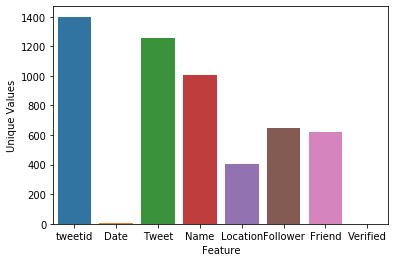

In [246]:
unique = df.nunique().reset_index()
unique.columns = ['Feature','Unique Values']
ax = sns.barplot(x='Feature', y='Unique Values', data=unique)
print(unique)

In [330]:
def plot_frekuensi(df, fitur, judul, pallete):
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[fitur], order = df[fitur].value_counts().index[:20], palette=pallete)
    g.set_title("Jumlah dan Frekuensi {}".format(judul))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frekuensi {} 20 terbanyak'.format(fitur))
    plt.ylabel('Frekuensi', fontsize=12)
    plt.xlabel(judul, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

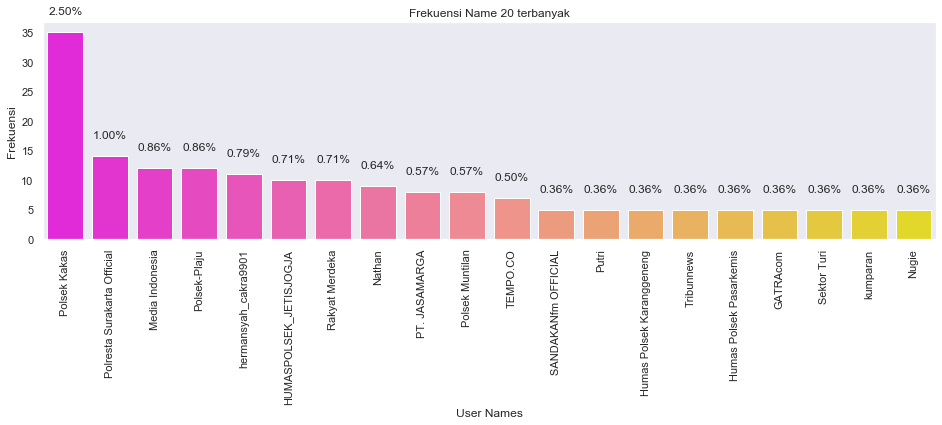

In [331]:
plot_frekuensi(df, 'Name', 'User Names','spring')

In [248]:
lokasi = pd.DataFrame(columns=['Kota'])
lokasi['Kota'] = df['Location'].dropna()
lokasi 

,Kota
3,Jl. A. Yani Km. 01 Kintapura
4,Kuala Lumpur Federal Territory
5,NUSWANTARA Cabang SUNDA
6,Indonesia
8,"Kota Banda Aceh, Nangro Aceh D"
...,...
1391,Indonesia
1392,Indonesia
1393,"中区, 新加坡"
1394,"Jakarta, Indonesia"


In [249]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs

alamat = "https://id.wikipedia.org/wiki/Daftar_kota_di_Indonesia_menurut_provinsi"
html = urlopen(alamat)
data = bs(html, 'html.parser')

In [250]:
table = data.findAll('table', {'class':'wikitable'})[0]
rows = table.findAll("tr")
kota=[]
for row in rows:
    cell=[]
    for item in row.findAll(["th","td"]): #gathering function
        cell.append(item.get_text().lower())
    kota.append(cell)
kotadf = pd.DataFrame(kota)
kotadf.columns = kotadf.iloc[0]
kotadf = kotadf[1:]
del kotadf['kawasan\n']
del kotadf['no.']
del kotadf['provinsi']
kotadf

,kota
1,banda aceh
2,langsa
3,lhokseumawe
4,meulaboh
5,sabang
...,...
95,pematangsiantar
96,sibolga
97,tanjungbalai
98,tebingtinggi


In [251]:
from nltk.tokenize import word_tokenize
import re
kota_new, fin = [], []       
        

for item in lokasi['Kota']:
    clean = item.lower()
    clean = ' '.join(re.sub("([0-9 \t]+)|([^0-9A-Za-z \t])", " ", clean).split()) 
    stop_words = set(kotadf['kota'])
    word_tokens = word_tokenize(clean) 
    clean = ' '.join([w for w in word_tokens if w in stop_words])
    if clean == '':
        pass
    else:
        town = word_tokenize(clean)
        town1 = town[0]
        kota_new.append(town1)
for kota in kota_new:
    fin.append(kota.capitalize())

['Bogor',
 'Yogyakarta',
 'Surabaya',
 'Palembang',
 'Pekanbaru',
 'Cirebon',
 'Magelang',
 'Magelang',
 'Surabaya',
 'Bekasi',
 'Bandung',
 'Batam',
 'Surakarta',
 'Bandung',
 'Surabaya',
 'Bengkulu',
 'Palembang',
 'Balikpapan',
 'Yogyakarta',
 'Serang',
 'Bekasi',
 'Semarang',
 'Bogor',
 'Palembang',
 'Batam',
 'Samarinda',
 'Depok',
 'Yogyakarta',
 'Surabaya',
 'Bekasi',
 'Bandung',
 'Bogor',
 'Bandung',
 'Serang',
 'Yogyakarta',
 'Magelang',
 'Depok',
 'Magelang',
 'Yogyakarta',
 'Pekalongan',
 'Bekasi',
 'Cirebon',
 'Denpasar',
 'Kupang',
 'Cirebon',
 'Semarang',
 'Yogyakarta',
 'Depok',
 'Bandung',
 'Surakarta',
 'Bekasi',
 'Semarang',
 'Batam',
 'Bekasi',
 'Malang',
 'Bekasi',
 'Bandung',
 'Bandung',
 'Surabaya',
 'Palopo',
 'Bandung',
 'Palopo',
 'Padang',
 'Pontianak',
 'Cirebon',
 'Pekanbaru',
 'Yogyakarta',
 'Surabaya',
 'Purwokerto',
 'Magelang',
 'Magelang',
 'Magelang',
 'Malang',
 'Depok',
 'Batam',
 'Surakarta',
 'Makassar',
 'Yogyakarta',
 'Bandung',
 'Dumai',
 'Ponti

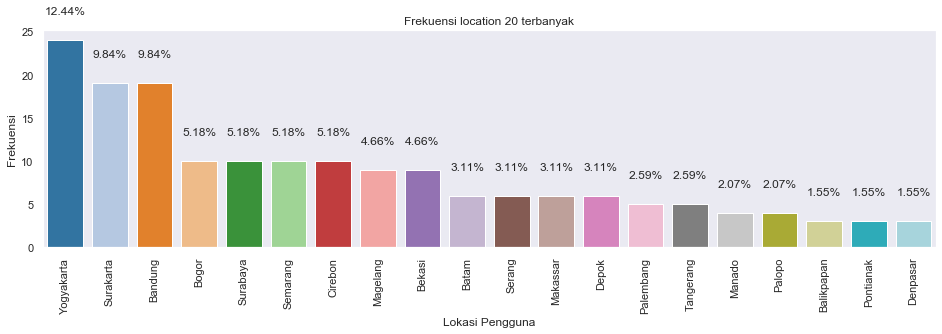

In [332]:
lokasi_df = pd.DataFrame(columns=['location'])
lokasi_df['location'] = fin

plot_frekuensi(lokasi_df, 'location', 'Lokasi Pengguna', 'tab20')

# Sentiment Analysis

In [471]:
import numpy as np
pos_list= open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()
res = []
for item in tweet:
    count_p = 0
    count_n = 0
    for kata_pos in pos_kata:
        if kata_pos.strip() in item:
            count_p +=1
    for kata_neg in neg_kata:
        if kata_neg.strip() in item:
            count_n +=1
    res.append(count_p - count_n)
mean = (np.mean(res))
stddev= (np.std(res))
print ("Nilai rata-rata: "+str(mean))
print ("Standar deviasi: "+str((stddev)))    

sentiment =[]
for item in res:
    if item<0:
        sentiment.append(2) #negatif
    if item == 0:
        sentiment.append(0) #netral
    if item > 0:
        sentiment.append(1) #positif

Nilai rata-rata: 0.36714285714285716
Standar deviasi: 2.146307222621578


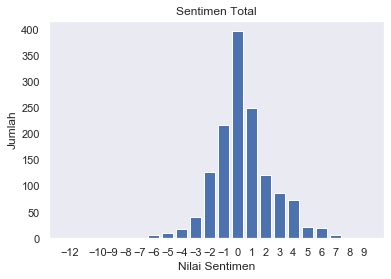

In [478]:
labels, counts = np.unique(res, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("Nilai Sentimen")
plt.ylabel("Jumlah")
plt.title('Sentimen Total')
plt.show()

In [474]:
connection = sqlite3.connect('hanaizdihar20_tugas12.db')
cursor = connection.cursor()

for row in df.index:
    tweet_id = df['tweetid'][row]
    tweet_id = int(tweet_id)
    sent = sentiment[row]
    nilai = res[row]
    query ='''INSERT OR IGNORE INTO Sentiment (tweetid, sentiment, value) 
          VALUES (?,?,?);'''
    val_tweet = [tweet_id, sent, nilai]
    cursor.execute(query, val_tweet)

connection.commit()
cursor.close()
connection.close()

In [481]:
def sentimen_per_hari():
    connection = sqlite3.connect('hanaizdihar20_tugas12.db')
    cursor = connection.cursor()
    for x in range(7):
        a=x+1
        tanggal = "2020-11-2"+ str(a)
        sql = "select value from Sentiment a inner join Tweet b on a.tweetid = b.tweetid where createddate = ?"
        val = [tanggal]
        cursor.execute(sql,val)
        data = cursor.fetchall()
        globals()["nilai" + str(a)] = pd.DataFrame(data)

    #show plot
    for x in range(7):
        a=x+1
        title = "2020-11-2" + str(a)
        labels, counts = np.unique(globals()["nilai" + str(a)][0], return_counts=True)
        plt.bar(labels, counts, align='center')
        plt.gca().set_xticks(labels)
        plt.title(title)
        plt.ylabel('Jumlah')
        plt.xlabel('Nilai Sentimen')
        plt.show()
    
    cursor.close()
    connection.close() 

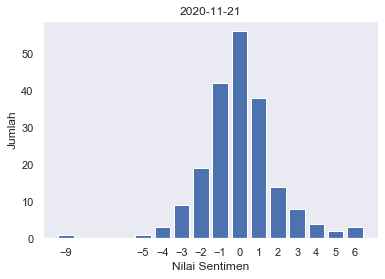

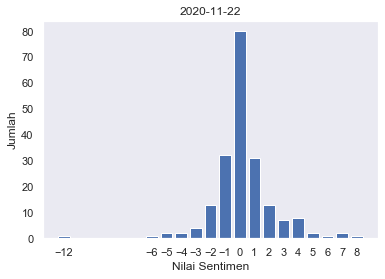

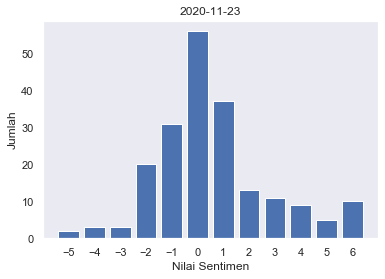

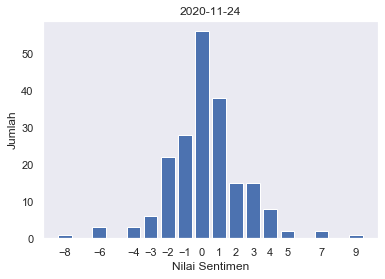

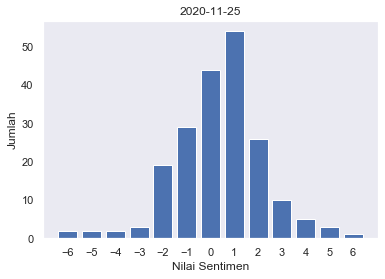

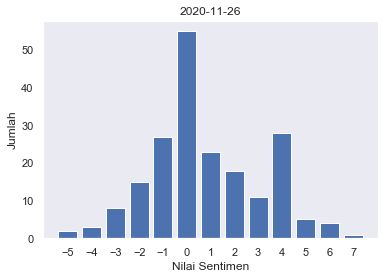

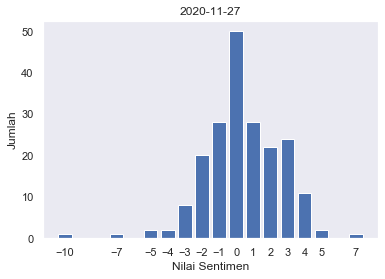

In [482]:
sentimen_per_hari()

In [339]:
kapos, kaneg=[], []
for item in tweet:
    for kata_pos in pos_kata:
        if kata_pos.strip() in item:
            kapos.append(kata_pos)
    for kata_neg in neg_kata:
        if kata_neg.strip() in item:
            kaneg.append(kata_neg)
kapos = [item.replace("\n", "") for item in kapos]
kaneg = [item.replace("\n", "") for item in kaneg]
dfpos= pd.DataFrame(columns=['kata positif'])
dfneg = pd.DataFrame(columns=['kata negatif'])
dfpos['kata positif'] = kapos
dfneg['kata negatif'] = kaneg

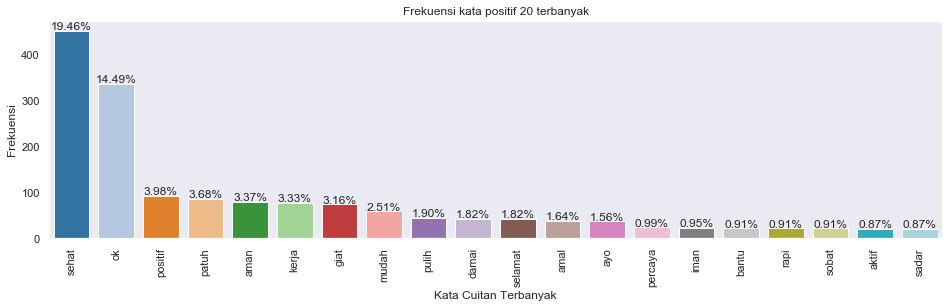

In [336]:
plot_frekuensi(dfpos, 'kata positif', 'Kata Cuitan Terbanyak', 'tab20')

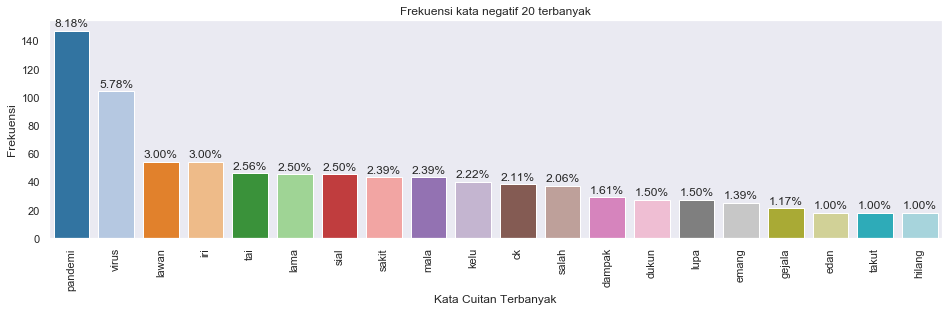

In [340]:
plot_frekuensi(dfneg, 'kata negatif', 'Kata Cuitan Terbanyak', 'tab20')

<FreqDist with 5400 samples and 20840 outcomes>
[('covid', 1529), ('yg', 243), ('sehat', 231), ('cegah', 178), ('protokol', 163), ('pandemi', 162), ('sebar', 120), ('pilkada', 114), ('positif', 96), ('ya', 96)]


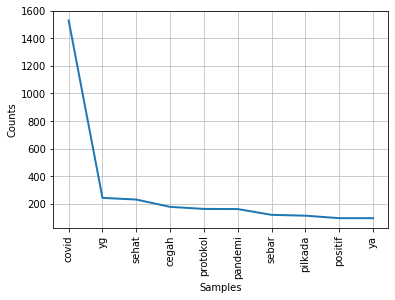

In [267]:
#word cloud
import itertools
from nltk.probability import FreqDist

kata_terbanyak = [word_tokenize(kalimat) for kalimat in tweet]
kata_terbanyak = list(itertools.chain(*kata_terbanyak))
frekuensi = FreqDist(kata_terbanyak)
print(frekuensi)
print(frekuensi.most_common(10))
frekuensi.plot(10,cumulative=False)
plt.show()

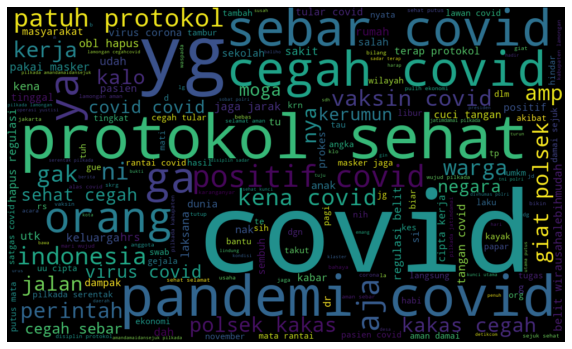

In [270]:
from wordcloud import WordCloud

data = ' '.join(kata_terbanyak)
cloud = WordCloud(width=1000, height=600, max_font_size=200).generate(data)
plt.figure(figsize=(10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Webscraping Kompas

In [365]:
#webscraping
query = '''SELECT a.tweetid, a.sentiment, b.cleantweet from Sentiment a inner join Tweet b on a.tweetid = b.tweetid '''

connection = sqlite3.connect('hanaizdihar20_tugas12.db')
cursor = connection.cursor()
cursor.execute(query)
hasil = cursor.fetchall()
cursor.close()
connection.close()

dfsen = pd.DataFrame(columns=['tweetid','Sentiment', 'tweet'])
tweetid2, sentiment, tweet2 = [], [], []
for item in hasil:
    tweetid2.append(item[0])
    sentiment.append(item[1])
    tweet2.append(item[2])

dfsen['tweetid'] = tweetid2
dfsen['Sentiment']= sentiment
dfsen['tweet']= tweet2
dfsen['tweetid'] = pd.to_numeric(dfsen['tweetid'])
dfsen['Sentiment'] = pd.to_numeric(dfsen['Sentiment'])
dfsen.head()

,tweetid,Sentiment,tweet
0,1330287374463623172,2,presiden ri joko widodo jokowi klaim omnibus l...
1,1330287671583838209,1,dennysiregar doa manjur hrs ga sampe minggu la...
2,1330287692731584516,2,orchidpoison tahun covid bener bener diet air ...
3,1330287714529390597,2,cegah covid belanja pandemi covid diam rumah t...
4,1330287856485588998,0,sarawak catat sifar kes covid pkpb kuching tamat


In [371]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import GaussianNB 

vectorizer = TfidfVectorizer()
model_g = GaussianNB()

#ubah ke tf idf vectorizer
tfidf_data = vectorizer.fit_transform(dfsen['tweet']).toarray()
print (tfidf_data)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.61789874 0.        ]]


# Webscraping 

In [487]:
import pprint
import requests
secret ='41a4dc43e8284eeb87757d1978d9b36b'
url = 'https://newsapi.org/v2/everything?'
parameters = {
    'q': 'covid', # query phrase
    'pageSize': 20,  # maximum is 100
    'apiKey': secret, # your own API key
    'from_param':'2020-11-21',
    'to':'2020-11-27',
    'language':'id'
}

In [488]:
response = requests.get(url, params=parameters)
response_json = response.json()
pprint.pprint(response_json)

{'articles': [{'author': 'detikTV, dtv',
               'content': 'Jakarta - Legenda AS Roma, Francesco Totti, '
                          'dinyatakan positif Covid-19. Bintang sepakbola '
                          'Italia itu mengalami gejala demam.\r\n'
                          'Kondisi Totti saat ini sudah dikabarkan mulai '
                          'membaik. Sebelumnya eks ka… [+100 chars]',
               'description': 'Legenda AS Roma, Francesco Totti, dinyatakan '
                              'positif Covid-19. Bintang sepakbola Italia itu '
                              'mengalami gejala demam.',
               'publishedAt': '2020-11-03T00:46:48Z',
               'source': {'id': None, 'name': 'Detik.com'},
               'title': 'Francesco Totti Positif Covid-19',
               'url': 'https://sport.detik.com/detiktv/d-5239087/francesco-totti-positif-covid-19',
               'urlToImage': 'https://awsimages.detik.net.id/api/wm/2017/05/29/ae6b1177-77e1-420e-8e14-830ae6

In [507]:
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
import itertools
from nltk.probability import FreqDist
from wordcloud import WordCloud
import re


def bersihkan(teks):
    indonesia_s = stopwords.words('indonesian')
    indonesia_s.append('yg')
    indonesia_s.append('ya')
    indonesia_s.append('nih')
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    teks = teks.lower()
    teks = ' '.join(re.sub("([0-9 \t]+)|([^0-9A-Za-z \t])", " ", teks).split())
    stop_words = set(indonesia_s)
    word_tokens = word_tokenize(teks)
    teks = ' '.join([w for w in word_tokens if not w in stop_words])
    teks = stemmer.stem(teks)
    return teks

def nilai_sentimen(teks):
    pos_list = open("./kata_positif.txt", "r")
    pos_kata = pos_list.readlines()
    neg_list = open("./kata_negatif.txt", "r")
    neg_kata = neg_list.readlines()
    count_p = 0
    count_n = 0
    for kata_pos in pos_kata:
        if kata_pos.strip() in teks:
            count_p += 1
    for kata_neg in neg_kata:
        if kata_neg.strip() in teks:
            count_n += 1
    sentimen = count_p - count_n
    return sentimen

def plot(list_teks):
    df_plot= pd.DataFrame(columns=['sentiment'])
    df_plot['sentiment']=list_teks
    labels, counts = np.unique(df_plot["sentiment"], return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.xlabel('Nilai Sentimen')
    plt.ylabel('Jumlah')
    plt.title('Sentimen Berita')
    plt.show()

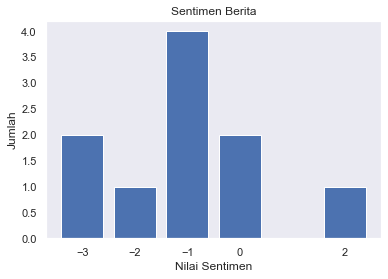

In [508]:
sentimen2, clean2 =[], []
for i in response_json['articles']:
    clean=bersihkan(i['title'])
    sen = nilai_sentimen(clean)
    clean2.append(clean)
    sentimen2.append(sen)
plot(sentimen2)

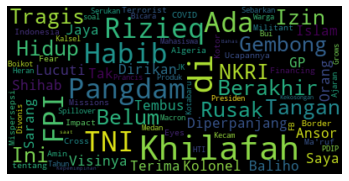

In [506]:
teks_gabungan = ''
 
for i in response_json['articles']:
    teks_gabungan += i['title'] + ' ' 
    
wordcloud = WordCloud(max_font_size=40).generate(teks_gabungan)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()